I'll generate different models applying on the dataset created with the feature engineering, PCA data with 3 components and balanced data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# some models to compare
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
dir_in = "C:/Users/barre/Desktop/Machine Learning/projects/bank/in/{}"

In [3]:
df = pd.read_csv(dir_in.format('data_selection.csv'))
df_balanced = pd.read_csv(dir_in.format('data_balanced.csv'))
df_pca = pd.read_csv(dir_in.format('data_pca.csv')) 

In [4]:
df.head(2)

,Total_Trans_Ct,Total_Revolving_Bal,Total_Relationship_Count,Months_Inactive_12_mon,Target
0,42,777,5,1,1
1,33,864,6,1,1


In [5]:
df_balanced.head(2)

,Total_Trans_Ct,Total_Revolving_Bal,Total_Relationship_Count,Months_Inactive_12_mon,Target
0,42,777,5,1,1
1,33,864,6,1,1


In [6]:
df_pca.head(2)

,f1,f2,f3,Target
0,-1.236407,-0.503494,0.910693,1
1,-1.827758,-0.191032,1.080123,1


In [7]:
# features & target
X = df.drop('Target', axis=1)

# standarizing data
X = StandardScaler().fit_transform(X)
y = df['Target']

# features & target balanced data
X_bal = df_balanced.drop('Target', axis=1)
X_bal = StandardScaler().fit_transform(X_bal)
y_bal = df_balanced['Target']

# features & target PCA
X_pca = df_pca.drop('Target', axis=1)
y_pca = df_pca['Target']

In [8]:
# train & test variables for each dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.3, random_state = 42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, random_state = 42)

In [9]:
len(X_train_bal) / len(X_bal) * 100

69.99575010624734

Let's see a first look with one model on each dataset

In [10]:
rf_model = RandomForestClassifier()
rf_model_bal = RandomForestClassifier()
rf_model_pca = RandomForestClassifier()


rf_model.fit(X_train, y_train)
rf_model_bal.fit(X_train_bal, y_train_bal)
rf_model_pca.fit(X_train_pca, y_train_pca)

y_pred = rf_model.predict(X_test)
y_pred_bal = rf_model_bal.predict(X_test_bal)
y_pred_pca = rf_model_pca.predict(X_test_pca)

print("Normal model:", rf_model.score(X_test, y_test))
print("Balanced model:", rf_model_bal.score(X_test_bal, y_test_bal))
print("PCA model:", rf_model_pca.score(X_test_pca, y_test_pca))

Normal model: 0.9047294998298742
Balanced model: 0.928328611898017
PCA model: 0.8676420551207894


It seems the model with feature engineering works well, a little improvement with balanced, but low score with PCA data.

### Modeling with ensembles

#### Bagging:

In [11]:
from sklearn.ensemble import BaggingClassifier

estimators = {
        'KNeighbors' : KNeighborsClassifier(),
        'LogisticRegression' : LogisticRegression(),
        'DecisionTree' : DecisionTreeClassifier(),
        'RandomForest' : RandomForestClassifier()
    }

for name, estimator in estimators.items():
        estimator.fit(X_train, y_train)
        prediction = estimator.predict(X_test)
        print("--" * 32)
        print(
            f'Score of {name} model: {"%.3f" % accuracy_score(prediction, y_test)}',
            "\n")
        print(" **** Improving with Bagging Ensemble ****")

        bag_class = BaggingClassifier(base_estimator=estimator,
                                      n_estimators=50).fit(X_train, y_train)
        bag_pred = bag_class.predict(X_test)

        print(
            f'Bagging score with {name} model: {"%.3f" % accuracy_score(bag_pred, y_test)}',
            "\n")

----------------------------------------------------------------
Score of KNeighbors model: 0.911 

 **** Improving with Bagging Ensemble ****
Bagging score with KNeighbors model: 0.912 

----------------------------------------------------------------
Score of LogisticRegression model: 0.884 

 **** Improving with Bagging Ensemble ****
Bagging score with LogisticRegression model: 0.884 

----------------------------------------------------------------
Score of DecisionTree model: 0.868 

 **** Improving with Bagging Ensemble ****
Bagging score with DecisionTree model: 0.901 

----------------------------------------------------------------
Score of RandomForest model: 0.908 

 **** Improving with Bagging Ensemble ****
Bagging score with RandomForest model: 0.913 



KNeighbors and RandomForest are the best models!

#### Boosting:

Accuracy score: 0.9149370534195305


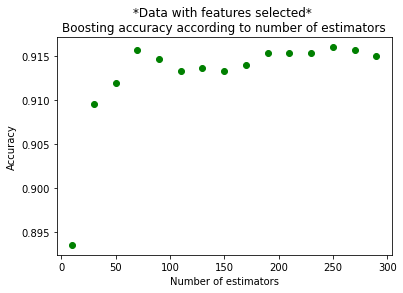

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

for num in range(10, 300, 20):
    # How many estimators? We need to change and see, or apply cross validation.
    boost = GradientBoostingClassifier(n_estimators=num)
    boost.fit(X_train, y_train)
    boost_pred = boost.predict(X_test)

    plt.plot(num, accuracy_score(boost_pred, y_test), 'o', color='green');
    
    if num == 290:
        print("Accuracy score:", accuracy_score(boost_pred, y_test))

plt.title("*Data with features selected* \nBoosting accuracy according to number of estimators");
plt.xlabel("Number of estimators");
plt.ylabel("Accuracy");

It looks with only 70 estimators we obtain more than 91% of accuracy, more is unnecesary.

In [13]:
boost = GradientBoostingClassifier(n_estimators=70)
boost.fit(X_train, y_train)
boost_pred = boost.predict(X_test)

print("Accuracy score normal data:", accuracy_score(boost_pred, y_test))

Accuracy score normal data: 0.9156175569921742


Accuracy score balanced data: 0.886685552407932


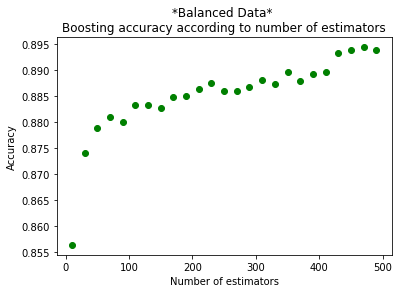

In [14]:
for num in range(10, 500, 20):
    # How many estimators? We need to change and see, or apply techniques with cross validation.
    boost = GradientBoostingClassifier(n_estimators=num)
    boost.fit(X_train_bal, y_train_bal)
    boost_pred = boost.predict(X_test_bal)

    plt.plot(num, accuracy_score(boost_pred, y_test_bal), 'o', color='green');
    
    if num == 290:
        print("Accuracy score balanced data:", accuracy_score(boost_pred, y_test_bal))

plt.title("*Balanced Data* \nBoosting accuracy according to number of estimators");
plt.xlabel("Number of estimators");
plt.ylabel("Accuracy");

Balanced data requires a lot more estimators to have a little improve in our performance...

### Improving the model with parametric optimization

In [15]:
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier()

rf_parameters = {
    'n_estimators' : range(50, 150, 10),
    'max_depth' : range(4, 14, 2)
}

rand_normal = RandomizedSearchCV(rf_model,
                                 rf_parameters,
                                 n_iter=5,
                                 cv=3)

rand_bal = RandomizedSearchCV(rf_model,
                              rf_parameters,
                              n_iter=5,
                              cv=3)

# Let's see what model works better, balanced or unbalanced
rand_normal.fit(X_train, y_train)
rand_bal.fit(X_train_bal, y_train_bal)

print("-------- RandomForest unbalanced data --------")
print(rand_normal.best_estimator_)
print(rand_normal.best_params_)
print("best score RandomForest:", np.abs(rand_normal.best_score_))

print("\n-------- RandomForest balanced data --------")
print(rand_bal.best_estimator_)
print(rand_bal.best_params_)
print("best score RandomForest:", np.abs(rand_bal.best_score_))

-------- RandomForest unbalanced data --------
RandomForestClassifier(max_depth=6, n_estimators=130)
{'n_estimators': 130, 'max_depth': 6}
best score RandomForest: 0.9152694261138583

-------- RandomForest balanced data --------
RandomForestClassifier(max_depth=12, n_estimators=60)
{'n_estimators': 60, 'max_depth': 12}
best score RandomForest: 0.8989678202792956


### So... Which one is better?
Not everything is score. We need more indicators to check the performance of models...

# Confusion Matrix

In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

confusion_mtx = metrics.confusion_matrix(y_test, y_pred)
confusion_mtx = pd.DataFrame(confusion_mtx)

confusion_bal = metrics.confusion_matrix(y_test_bal, y_pred_bal)
confusion_bal = pd.DataFrame(confusion_bal)

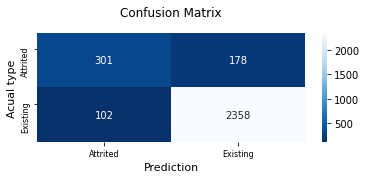

In [17]:
plt.figure(figsize=(6, 2))
sns.heatmap(confusion_mtx, annot=True, cmap="Blues_r", fmt='g');

plt.title('Confusion Matrix', y=1.1);
plt.ylabel('Acual type', size=11, loc="center");
plt.yticks([0.3,1.3], labels=['Attrited', 'Existing'], rotation=90, size=8);
plt.xlabel('Prediction', size=11);
plt.xticks([0.5, 1.5], ['Attrited', 'Existing'], rotation=0, size=8);

Our model isn't perfect, there's a lot of values that are not recognized, specially on attrited customers. This is because the unbalance.

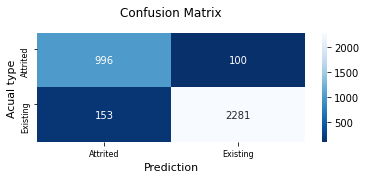

In [18]:
plt.figure(figsize=(6, 2))
sns.heatmap(confusion_bal, annot=True, cmap="Blues_r", fmt='g');

plt.title('Confusion Matrix', y=1.1);
plt.ylabel('Acual type', size=11, loc="center");
plt.yticks([0.3,1.3], labels=['Attrited', 'Existing'], rotation=90, size=8);
plt.xlabel('Prediction', size=11);
plt.xticks([0.5, 1.5], ['Attrited', 'Existing'], rotation=0, size=8);

Let's check precision/recall metrics

## Precision/Recall

In [19]:
confusion_mtx.loc[0,1]

178

In [20]:
true_positives = confusion_mtx.loc[0,0]
false_positives = confusion_mtx.loc[1,0]
true_negatives = confusion_mtx.loc[1,1]
false_negatives = confusion_mtx.loc[0,1]

total_points = true_positives + false_positives + true_negatives + false_negatives

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
accuracy = (true_positives + true_negatives) / (total_points)

f1_score = (2*precision*recall / (precision + recall))


print("---- Unbalanced Model ----\n")
print(f'precision: {precision}') # total attrited correct / total attrited side obs
print(f'recall: {recall}') # total attrited correct / total actual attrited
print(f'accuracy: {accuracy}') # 'Total Correct / Total Observations'
print("--"*22)
print(f'F1 score: {f1_score}')

---- Unbalanced Model ----

precision: 0.7468982630272953
recall: 0.6283924843423799
accuracy: 0.9047294998298742
--------------------------------------------
F1 score: 0.6825396825396826


In [21]:
true_positives = confusion_bal.loc[0,0]
false_positives = confusion_bal.loc[1,0]
true_negatives = confusion_bal.loc[1,1]
false_negatives = confusion_bal.loc[0,1]

total_points = true_positives + false_positives + true_negatives + false_negatives

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
accuracy = (true_positives + true_negatives) / (total_points)

f1_score = (2*precision*recall / (precision + recall))


print("------ Balanced Model ------\n")
print(f'precision: {precision}')
print(f'recall: {recall}') # % attrited customer that we can identify
print(f'accuracy: {accuracy}') 
print("--"*22)
print(f'F1 score: {f1_score}')

------ Balanced Model ------

precision: 0.8668407310704961
recall: 0.9087591240875912
accuracy: 0.928328611898017
--------------------------------------------
F1 score: 0.8873051224944322


Now we have lot more better metrics! The model can identify more attrited customers and with lot better results!

In [22]:
model = RandomForestClassifier(max_depth=12, n_estimators=50)
model.fit(X_train_bal, y_train_bal)

print("best score RandomForest:", model.score(X_test, y_test))

best score RandomForest: 0.8986049676760803


In [23]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(model, X_bal, y_bal, cv=3)

precisions, recalls, thresholds = precision_recall_curve(y_bal, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Thresholds")
    plt.legend(loc="center right", fontsize=10) 

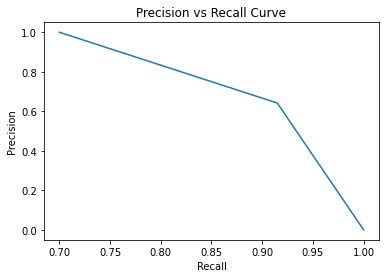

In [24]:
plt.plot(precisions, recalls);
plt.title("Precision vs Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision");

Not the best curve that we want, but acceptable. We get 90% recall with 65% precision. 95% recall with 40% precision.

### Underfitting / Overfitting
Let's see how model works on external data

In [25]:
from sklearn.model_selection import cross_validate

results = cross_validate(model, X_bal, y_bal, return_train_score=True, cv=5)
test_score = results['test_score']
train_score = results['train_score']

print(f'train score: {np.mean(train_score)}')
print(f'test score: {np.mean(test_score)}')

train score: 0.9510199745006375
test score: 0.8901827454313642


Not bad, model can improve but is a good result. This means that our model has low variance, since as it learns with train data, it also generalizes that learning to external data!

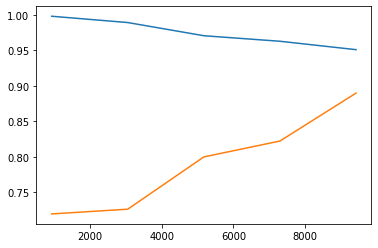

In [26]:
from sklearn.model_selection import learning_curve

lc = learning_curve(model, X_bal, y_bal, cv=5)
samples, train, test = lc[0], lc[1], lc[2]

plt.plot(samples, np.mean(train, axis=1));
plt.plot(samples, np.mean(test, axis=1));

It seems that the model can learn a bit more, not too much because is very close to hitting the blue line on 90%.

# Decision
**I'll chose balanced data with the features manually selected and model using boosting ensemble**

According to the parametric optimization with RandomizedSearchCV. RandomForest works a little bit better with unbalanced data!

**We have less score than balance data, but better performance!** This model identifies with more precision attrited customers than the other one. This is the goal.